In [2]:
#Includes necesarios
from sklearn.neighbors import KNeighborsClassifier

import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

from preprocessing import get_train_validation
from preprocessing import apply_OHE,standarize,normalize

from sklearn.metrics import classification_report
from plot_metrics import plot_cm, plot_roc_curve

# KNN

## Preprocesamiento: OHE

Obtenemos los datos de entrenamiento y de validacion

In [3]:
X_train, X_validation, y_train, y_validation = get_train_validation()

Para entrenar KNN necesitamos aplicar OHE en las columnas categoricas, para esto llamamos a la funcion de preprocesamiento **aplicar_OHE**:

In [4]:
X_train = apply_OHE(X_train)
X_validation = apply_OHE(X_validation)

Busco los mejores hiperparametros para el arbol de decision con randomsearch:

In [5]:
'''params = {
    'n_neighbors': np.arange(200, 300),
    'weights': ["uniform","distance"],
}

clf = KNeighborsClassifier()

rgscv = RandomizedSearchCV(
    clf, params, n_iter=60, scoring='accuracy', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")
n_neighbors = rgscv.best_params_.get("n_neighbors")
weights = rgscv.best_params_.get("weights")'''

'params = {\n    \'n_neighbors\': np.arange(200, 300),\n    \'weights\': ["uniform","distance"],\n}\n\nclf = KNeighborsClassifier()\n\nrgscv = RandomizedSearchCV(\n    clf, params, n_iter=60, scoring=\'accuracy\', n_jobs=-1, cv=5, return_train_score=True\n).fit(X_train, y_train)\n\nprint(f"Best score: {rgscv.best_score_}")\nprint(f"Best params {rgscv.best_params_}")\nn_neighbors = rgscv.best_params_.get("n_neighbors")\nweights = rgscv.best_params_.get("weights")'

Armo el modelo de KNN con los hiperparametros calculados:

In [6]:
model_knn = KNeighborsClassifier(n_neighbors=21,weights='distance')

Entreno el modelo con el train set:

In [7]:
model_knn.fit(X_train, y_train)

C:\Users\lbca-pc\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=21, weights='distance')

Predigo con el validation set:

In [8]:
knn_predict = model_knn.predict(X_validation)

## Metricas

In [9]:
print(classification_report(y_validation, knn_predict))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90      4944
           1       0.70      0.62      0.66      1568

    accuracy                           0.84      6512
   macro avg       0.79      0.77      0.78      6512
weighted avg       0.84      0.84      0.84      6512



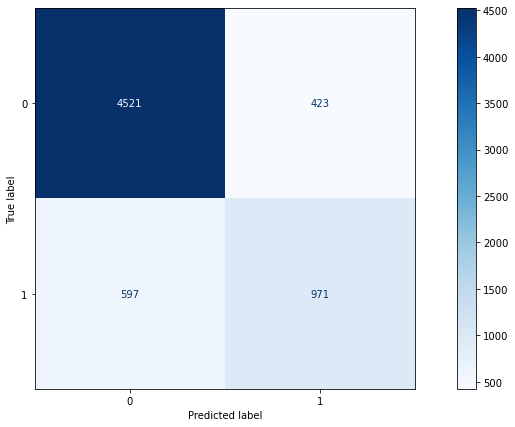

In [10]:
plot_cm(model_knn, X_validation, y_validation)

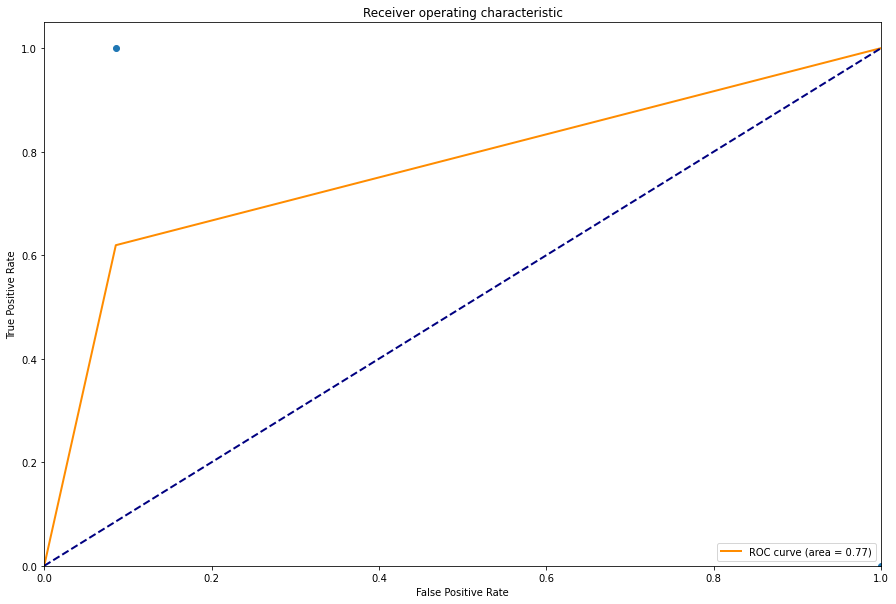

In [11]:
plot_roc_curve(y_validation,knn_predict)

## Preprocesamiento: OHE + ESTANDARIZACION

Obtenemos los datos de entrenamiento y de validacion

In [12]:
X_train, X_validation, y_train, y_validation = get_train_validation()

Para entrenar KNN necesitamos aplicar OHE en las columnas categoricas, para esto llamamos a la funcion de preprocesamiento **apply_OHE** y **estandarized**:

In [13]:
X_train = apply_OHE(X_train)
X_train = standarize(X_train)
X_validation = apply_OHE(X_validation)
X_validation = standarize(X_validation)

In [31]:
X_train_aux = pd.DataFrame(X_train)
X_train_aux

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,0.311046,0.544331,0.0,0.777616,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.214320,0.392920,0.0,0.893000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.01786,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.211588,0.906804,0.0,0.362722,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.015113,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.271779,0.689900,0.0,0.668994,0.0,0.0,0.0,0.0,0.0,0.0,...,0.020906,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.274372,0.468046,0.0,0.839256,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,0.291932,0.718602,0.0,0.628777,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022456,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
26044,0.221056,0.742116,0.0,0.631588,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
26045,0.268242,0.715313,0.0,0.643782,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.017883,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
26046,0.345218,0.467059,0.0,0.812277,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.020307,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


Busco los mejores hiperparametros para el arbol de decision con randomsearch:

In [15]:
'''params = {
    'n_neighbors': np.arange(200, 300),
    'weights': ["uniform","distance"],
}

clf = KNeighborsClassifier()

rgscv = RandomizedSearchCV(
    clf, params, n_iter=60, scoring='accuracy', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")
n_neighbors = rgscv.best_params_.get("n_neighbors")
weights = rgscv.best_params_.get("weights")'''

'params = {\n    \'n_neighbors\': np.arange(200, 300),\n    \'weights\': ["uniform","distance"],\n}\n\nclf = KNeighborsClassifier()\n\nrgscv = RandomizedSearchCV(\n    clf, params, n_iter=60, scoring=\'accuracy\', n_jobs=-1, cv=5, return_train_score=True\n).fit(X_train, y_train)\n\nprint(f"Best score: {rgscv.best_score_}")\nprint(f"Best params {rgscv.best_params_}")\nn_neighbors = rgscv.best_params_.get("n_neighbors")\nweights = rgscv.best_params_.get("weights")'

Armo el modelo de KNN con los hiperparametros calculados:

In [16]:
model_knn = KNeighborsClassifier(n_neighbors=21,weights='distance')

Entreno el modelo con el train set:

In [17]:
model_knn.fit(X_train, y_train)

C:\Users\lbca-pc\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=21, weights='distance')

Predigo con el validation set:

In [18]:
knn_predict = model_knn.predict(X_validation)

## Metricas

In [19]:
print(classification_report(y_validation, knn_predict))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      4944
           1       0.68      0.57      0.62      1568

    accuracy                           0.83      6512
   macro avg       0.78      0.74      0.76      6512
weighted avg       0.83      0.83      0.83      6512



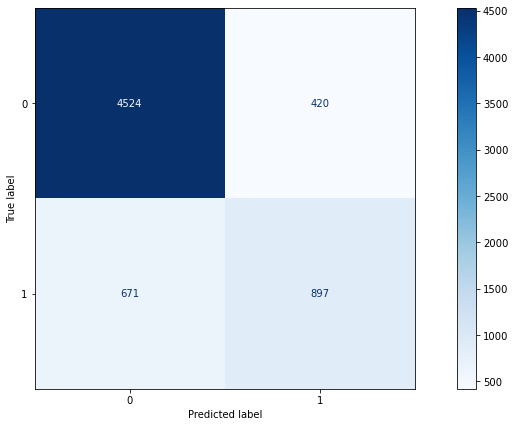

In [20]:
plot_cm(model_knn, X_validation, y_validation)

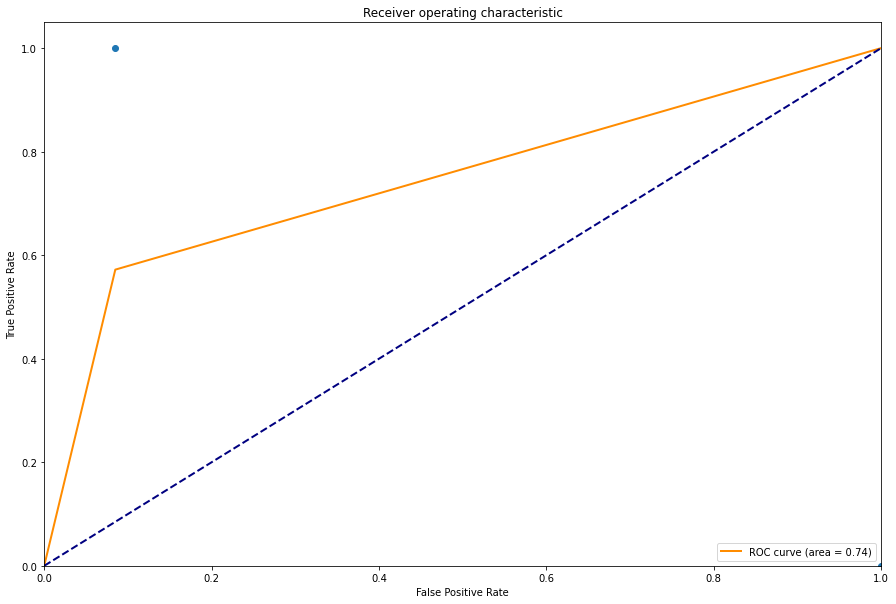

In [21]:
plot_roc_curve(y_validation,knn_predict)

## Preprocesamiento: OHE + NORMALIZACION

Obtenemos los datos de entrenamiento y de validacion

In [22]:
X_train, X_validation, y_train, y_validation = get_train_validation()

Para entrenar KNN necesitamos aplicar OHE en las columnas categoricas, para esto llamamos a la funcion de preprocesamiento **apply_OHE** y **estandarized**:

In [23]:
X_train = apply_OHE(X_train)
X_train = normalize(X_train)
X_validation = apply_OHE(X_validation)
X_validation = normalize(X_validation)

Busco los mejores hiperparametros para el arbol de decision con randomsearch:

In [24]:
'''params = {
    'n_neighbors': np.arange(200, 300),
    'weights': ["uniform","distance"],
}

clf = KNeighborsClassifier()

rgscv = RandomizedSearchCV(
    clf, params, n_iter=60, scoring='accuracy', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")
n_neighbors = rgscv.best_params_.get("n_neighbors")
weights = rgscv.best_params_.get("weights")'''

'params = {\n    \'n_neighbors\': np.arange(200, 300),\n    \'weights\': ["uniform","distance"],\n}\n\nclf = KNeighborsClassifier()\n\nrgscv = RandomizedSearchCV(\n    clf, params, n_iter=60, scoring=\'accuracy\', n_jobs=-1, cv=5, return_train_score=True\n).fit(X_train, y_train)\n\nprint(f"Best score: {rgscv.best_score_}")\nprint(f"Best params {rgscv.best_params_}")\nn_neighbors = rgscv.best_params_.get("n_neighbors")\nweights = rgscv.best_params_.get("weights")'

Armo el modelo de KNN con los hiperparametros calculados:

In [25]:
model_knn = KNeighborsClassifier(n_neighbors=21,weights='distance')

Entreno el modelo con el train set:

In [26]:
model_knn.fit(X_train, y_train)

C:\Users\lbca-pc\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=21, weights='distance')

Predigo con el validation set:

In [27]:
knn_predict = model_knn.predict(X_validation)

## Metricas

In [28]:
print(classification_report(y_validation, knn_predict))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      4944
           1       0.64      0.62      0.63      1568

    accuracy                           0.82      6512
   macro avg       0.76      0.75      0.76      6512
weighted avg       0.82      0.82      0.82      6512



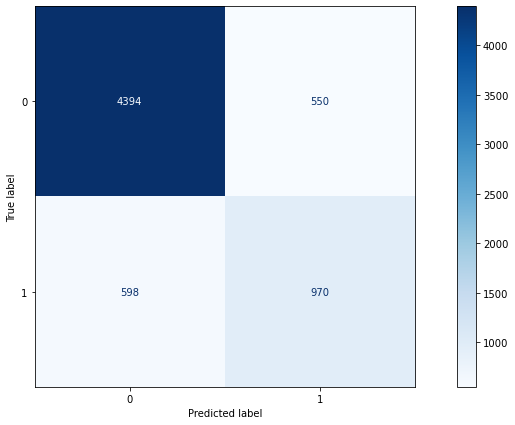

In [29]:
plot_cm(model_knn, X_validation, y_validation)

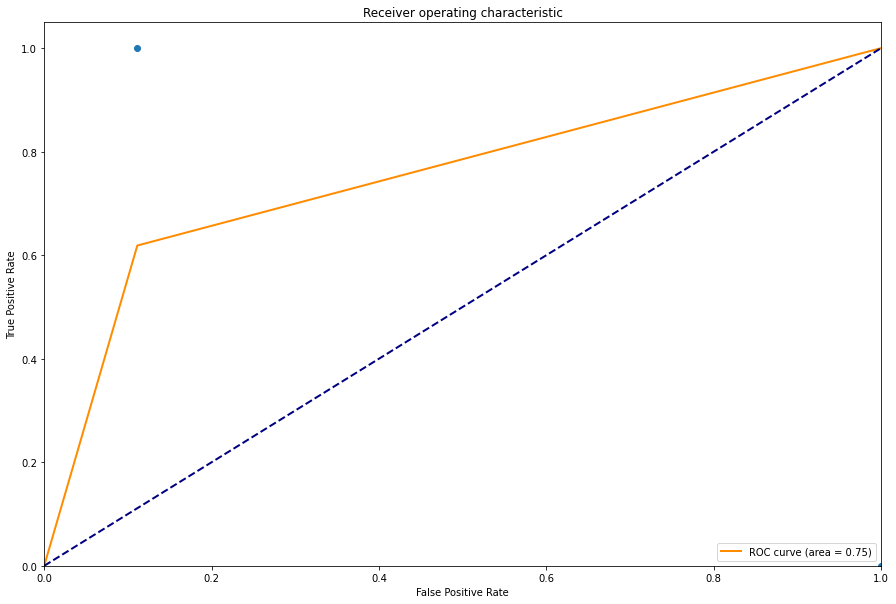

In [30]:
plot_roc_curve(y_validation,knn_predict)